# 基于PyTorch训练和部署MNIST图片分类模型

PyTorch是一个非常流行的深度学习框架，提供了极高的灵活性和优越的性能，能够与Python丰富的生态无缝结合，被广泛应用于图像分类、语音识别、自然语言处理、推荐、AIGC等领域。本示例中，我们将使用PAI Python SDK，在PAI完成一个PyTorch模型的训练，然后使用训练获得的模型部署推理服务。主要流程包括：

- Step1: 安装和配置SDK

安装PAI Python SDK，并配置使用的AccessKey、工作空间以及OSS Bucket。

- Step2: 准备训练数据

我们下载一个MNIST数据集，上传到OSS上供训练作业使用。

- Step3: 准备训练脚本

我们使用PyTorch示例仓库中的MNIST训练脚本作为模板，在简单修改之后作为训练脚本。

- Step4: 提交训练作业

使用PAI Python SDK提供的Estimator API，创建一个训练作业，提交到云上执行。

- Step5: 部署推理服务

将以上训练作业输出的模型，分别使用Processor和镜像部署的方式部署到PAI-EAS，创建在线推理服务。



## Step1: 安装和配置SDK

我们需要首先安装PAI Python SDK以运行本示例。

In [ ]:
!python -m pip install --upgrade alipai
!python -m pip install pandas



SDK需要配置访问阿里云服务需要的AccessKey，以及当前使用的工作空间和OSS Bucket。在PAI SDK安装之后，通过在**命令行终端** 中执行以下命令，按照引导配置密钥、工作空间等信息。


```shell

# 以下命令，请在 命令行终端 中执行.

python -m pai.toolkit.config

```

我们可以通过以下代码验证配置是否已生效。

In [ ]:
import pai
from pai.session import get_default_session

print(pai.__version__)

sess = get_default_session()

# 获取配置的工作空间信息
assert sess.workspace_name is not None
print(sess.workspace_name)

## Step2: 准备训练数据

当前示例中，我们将使用MNIST数据集训练一个图片分类模型。为了支持训练作业加载使用，我们需要将数据上传到OSS Bucket上。


使用以下的Shell脚本，我们将MNIST数据集下载到本地目录data。

In [ ]:
%%sh

#!/bin/sh
set -e

url_prefix="https://ossci-datasets.s3.amazonaws.com/mnist/"
# 如果以上的地址下载速度较慢，可以使用以下地址
# url_prefix="http://yann.lecun.com/exdb/mnist/"

mkdir -p data/MNIST/raw/

wget ${url_prefix}train-images-idx3-ubyte.gz -P data/MNIST/raw/
wget ${url_prefix}train-labels-idx1-ubyte.gz -P data/MNIST/raw
wget ${url_prefix}t10k-images-idx3-ubyte.gz -P data/MNIST/raw
wget ${url_prefix}t10k-labels-idx1-ubyte.gz -P data/MNIST/raw


我们将使用PAI Python SDK提供的OSS上传API，将相应的数据上传到OSS Bucket上。

In [ ]:
from pai.common.oss_utils import upload
from pai.session import get_default_session

sess = get_default_session()
data_path = "./data"

data_uri = upload(data_path, oss_path="mnist/data/", bucket=sess.oss_bucket)

print(data_uri)

## Step3: 准备训练脚本

使用PyTorch训练模型，需要我们准备相应的脚本。这里我们以PyTorch官方提供的 [MNIST 示例](https://github.com/pytorch/examples/blob/main/mnist/main.py) 为基础，修改了数据加载和模型保存的逻辑，作为训练脚本。

- 使用环境变量获得输入数据路径

训练数据将被挂载到训练作业环境中使用，训练代码需要读取指定的路径获取训练数据。


```diff

-    dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
-    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

+	 # 使用挂载到训练容器中的数据，默认为 /ml/input/{ChannelName}，可以通过环境变量 `PAI_INPUT_{ChannelNameUpperCase}`
+    data_path = os.environ.get("PAI_INPUT_TRAIN_DATA")
+    dataset1 = datasets.MNIST(data_path, train=True, download=True, transform=transform)
+    dataset2 = datasets.MNIST(data_path, train=False, transform=transform)


```

- 使用环境变量获取模型的保存路径：

用户需要保存模型到工作容器中的指定路径，PAI的训练服务将其才能够持久化保存模型到OSS Bucket上。默认要求用户需要将模型保存到环境变量 `PAI_OUTPUT_MODEL` 指定的路径下（默认为`/ml/output/model`)。


```diff

-     if args.save_model:
-         torch.save(model.state_dict(), "mnist_cnn.pt")

+     # 保存模型
+     save_model(model)
+
+
+ def save_model(model):
+     """将模型转为TorchScript，保存到指定路径."""

+     output_model_path = os.environ.get("PAI_OUTPUT_MODEL")
+     os.makedirs(output_model_path, exist_ok=True)
+
+     m = torch.jit.script(model)
+     m.save(os.path.join(output_model_path, "mnist_cnn.pt"))

```

PAI提供的预置[PyTorch Processor](https://help.aliyun.com/document_detail/470458.html) 在创建服务时，要求输入的模型是[TorchScript 格式](https://pytorch.org/docs/stable/jit.html) 。在本示例中，我们将模型导出为 `TorchScript格式` ，然后分别使用 `PyTorch Processor` 和镜像方式创建推理服务。


运行以下代码，创建一个训练脚本目录。

In [ ]:
!mkdir -p train_src

将训练作业脚本保存到`train_src`训练脚本目录，完整的作业脚本如下：

In [ ]:
%%writefile train_src/train.py

# source: https://github.com/pytorch/examples/blob/main/mnist/main.py
from __future__ import print_function

import argparse
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


def main():
    # Training settings
    parser = argparse.ArgumentParser(description="PyTorch MNIST Example")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=14,
        metavar="N",
        help="number of epochs to train (default: 14)",
    )
    parser.add_argument(
        "--lr",
        type=float,
        default=1.0,
        metavar="LR",
        help="learning rate (default: 1.0)",
    )
    parser.add_argument(
        "--gamma",
        type=float,
        default=0.7,
        metavar="M",
        help="Learning rate step gamma (default: 0.7)",
    )
    parser.add_argument(
        "--no-cuda", action="store_true", default=False, help="disables CUDA training"
    )
    parser.add_argument(
        "--dry-run",
        action="store_true",
        default=False,
        help="quickly check a single pass",
    )
    parser.add_argument(
        "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=10,
        metavar="N",
        help="how many batches to wait before logging training status",
    )
    parser.add_argument(
        "--save-model",
        action="store_true",
        default=False,
        help="For Saving the current Model",
    )
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {"batch_size": args.batch_size}
    test_kwargs = {"batch_size": args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    data_path = os.environ.get("PAI_INPUT_TRAIN_DATA", "../data")
    dataset1 = datasets.MNIST(data_path, train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST(data_path, train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    # 保存模型
    save_model(model)


def save_model(model):
    """将模型转为TorchScript，保存到指定路径."""
    output_model_path = os.environ.get("PAI_OUTPUT_MODEL", "./model/")
    os.makedirs(output_model_path, exist_ok=True)

    m = torch.jit.script(model)
    m.save(os.path.join(output_model_path, "mnist_cnn.pt"))


if __name__ == "__main__":
    main()

## Step4: 提交训练作业

`Estimator`支持用户使用本地的训练脚本，以指定的镜像在云上执行训练作业。通过`Estimator`，我们将以上准备的训练作业脚本提交到PAI，使用PAI提供的PyTorch镜像执行训练任务。


In [ ]:
from pai.estimator import Estimator
from pai.image import retrieve


# 使用PAI提供的PyTorch的GPU训练镜像
image_uri = retrieve(
    "PyTorch",
    framework_version="1.8PAI",
    accelerator_type="GPU",
).image_uri

print(image_uri)


# 配置训练作业
est = Estimator(
    # 训练作业启动命令
    command="python train.py --epochs 5 --batch-size 256 --lr 0.5",
    # 需要上传的代码文件
    source_dir="./train_src/",
    # 训练作业镜像
    image_uri=image_uri,
    # 机器配置
    # PAI的训练服务支持机器实例类型请见文档：[公共资源组实例和定价](https://help.aliyun.com/document_detail/171758.html?#section-55y-4tq-84y)
    instance_type="ecs.gn6i-c4g1.xlarge",  # 4vCPU 15GB 1*NVIDIA T4
    # 训练作业的Metric捕获配置
    # 训练服务支持从训练作业输出日志中（训练脚本打印的标准输出和标准错误输出），以正则表达式匹配的方式捕获训练作业Metrics信息。
    metric_definitions=[
        {
            "Name": "loss",
            "Regex": r".*loss=([-+]?[0-9]*.?[0-9]+(?:[eE][-+]?[0-9]+)?).*",
        },
    ],
    base_job_name="pytorch_mnist",
)


`estimator.fit`方法将用户的训练作业提交到PAI上执行。任务提交之后，SDK会打印作业详情页链接和训练作业的日志，等待作业执行结束。

当用户需要直接使用OSS上数据，可以通过`estimator.fit`方法的`inputs`参数传递。通过`inputs`传递数据存储路径会被挂载到目录下，用户的训练脚本可以通过读取本地文件的方式加载数据。

In [ ]:
# 使用.fit方法提交训练作业
est.fit(
    inputs={
        # 训练作业的输入数据，每一个Key，Value对是一个Channel，用户可以通过环境变量PAI_INPUT_{ChannelNameUpperCase}获取对应的数据路径
        # 例如以下的train_data，训练的脚本中可以通过`PAI_INPUT_TRAIN_DATA`获取数据挂载后的路径.
        "train_data": data_uri,
    }
)

# 训练作业产出的模型路径
print("TrainingJob output model data:")
print(est.model_data())

## Step5: 部署推理服务

在训练作业结束之后，我们可以使用`estimator.model_data()`方法拿到训练作业产出模型的OSS路径。下面的流程中，我们将训练产出的模型部署到PAI创建在线推理服务。

部署推理服务的主要流程包括：

- 通过`InferenceSpec`描述如何使用模型构建推理服务

用户可以选择使用Processor或是自定义镜像的模式进行模型部署。以下示例中将分别使用两种方式部署获得的PyTorch模型。

- 通过`Model.deploy`方法，配置服务的使用资源，服务名称，等信息，创建推理服务。

对于部署推理服务的详细介绍，可以见: [文档:部署推理服务](https://pai-sdk.oss-cn-shanghai.aliyuncs.com/pai/doc/latest/user-guide/model.html)

### Processor 模式部署

[Processor](https://help.aliyun.com/document_detail/111029.html) 是PAI对于推理服务程序包的抽象描述，他负责加载模型并启动模型推理服务。模型推理服务会暴露API支持用户进行调用。

PAI提供了预置[PyTorch Processor](https://help.aliyun.com/document_detail/470458.html)，支持用户方便地将TorchScript格式的模型部署到PAI，创建推理服务。

以下示例代码中，我们通过PyTorch Processor将训练产出的模型部署为一个推理服务。

In [ ]:
from pai.model import Model, InferenceSpec
from pai.predictor import Predictor
from pai.common.utils import random_str


m = Model(
    model_data=est.model_data(),
    # 使用PAI提供的PyTorch Processor
    inference_spec=InferenceSpec(processor="pytorch_cpu_1.10"),
)

p: Predictor = m.deploy(
    service_name="tutorial_pt_mnist_proc_{}".format(random_str(6)),
    instance_type="ecs.c6.xlarge",
)

print(p.service_name)
print(p.service_status)

`Model.deploy`返回的`Predictor`对象指向创建的推理服务，可以通过`Predictor.predict`方法发送预测请求给到服务，拿到预测结果。

我们使用`numpy`构建了一个测试样本数据，发送给推理服务。

In [ ]:
import numpy as np

# # 以上保存TorchScript模型要求输入为 Float32, 数据格式格式的形状为 (BatchSize, Channel, Height, Width)
dummy_input = np.random.rand(2, 1, 28, 28).astype(np.float32)

# np.random.rand(1, 1, 28, 28).dtype
res = p.predict(dummy_input)
print(res)

print(np.argmax(res, 1))

在测试完成之后，可以通过`Predictor.delete_service`删除推理服务。

In [ ]:
p.delete_service()

### 镜像部署

Processor模式启动的推理服务性能优越，适合于对于性能较为敏感的场景。对于一些需要灵活自定义的场景，例如模型使用了一些第三方的依赖，或是推理服务需要有前处理和后处理，用户可以通过镜像部署的方式实现。

SDK提供了`pai.model.container_serving_spec()`方法，支持用户使用本地的推理服务代码配合PAI提供的基础镜像的方式创建推理服务。

在使用镜像部署之前，我们需要准备模型服务的代码，负责加载模型、拉起HTTP Server、处理用户的推理请求。我们将使用Flask编写一个模型服务的代码，示例如下：

In [ ]:
# 准备推理代码保存目录
!mkdir -p infer_src

In [ ]:
%%writefile infer_src/run.py


import json
from flask import Flask, request
from PIL import Image
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import io

app = Flask(__name__)
# 用户指定模型，默认会被加载到当前路径下。 
MODEL_PATH = "/eas/workspace/model/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(os.path.join(MODEL_PATH, "mnist_cnn.pt"), map_location=device).to(device)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)


@app.route("/", methods=["POST"])
def predict():
    # 预处理图片数据
    im = Image.open(io.BytesIO(request.data))
    input_tensor = transform(im).to(device)
    input_tensor.unsqueeze_(0)
    # 使用模型进行推理
    output_tensor = model(input_tensor)
    pred_res =output_tensor.detach().cpu().numpy()[0] 

    return json.dumps(pred_res.tolist())


if __name__ == '__main__':
    app.run(host="0.0.0.0", port=int(os.environ.get("LISTENING_PORT", 8000)))




通过`pai.model.container_serving_spec`，我们基于本地脚本和PAI提供的`PyTorch`镜像创建了一个`InferenceSpec`对象。

- 模型服务的代码和启动命令：
  
用户指定的本地脚本目录source_dir会被上传到OSS，然后挂载到服务容器（默认到 /ml/usercode目录）。

- 推理服务镜像：

PAI 提供了基础的推理镜像支持用户使用，用户可以通过`pai.image.retrieve`方法，指定参数`image_scope=ImageScope.INFERENCE`获取PAI提供的推理镜像。

- 模型服务的第三方依赖包：

模型服务代码或是模型的依赖，可以通过`requirements`参数指定，相应的依赖会在服务程序启动前被安装到环境中。


In [ ]:
from pai.model import InferenceSpec, container_serving_spec
from pai.image import retrieve, ImageScope

torch_image_uri = retrieve(
    framework_name="pytorch", framework_version="1.12", accelerator_type="CPU"
).image_uri

inf_spec = container_serving_spec(
    command="python run.py",
    source_dir="./infer_src/",
    image_uri=torch_image_uri,
    requirements=[
        "flask==2.2.2",
        "Werkzeug==2.3.7",
    ],
)
print(inf_spec.to_dict())

使用训练作业输出的模型，以及以上的 InferenceSpec，我们将通过 Model.deploy API部署一个在线推理服务。

In [ ]:
from pai.model import Model
from pai.common.utils import random_str
import numpy as np


m = Model(
    model_data=est.model_data(),
    inference_spec=inf_spec,
)

predictor = m.deploy(
    service_name="torch_mnist_script_container_{}".format(random_str(6)),
    instance_type="ecs.c6.xlarge",
)


我们准备一张 MNIST 测试图片，用于发送给到推理服务。


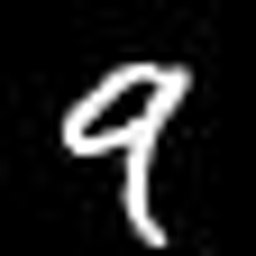

In [2]:

!pip install -q pillow


import base64
from PIL import Image
from IPython import display
import io


# raw_data是一张MNIST图片，对应数字9
raw_data = base64.b64decode(b"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+rVhpmoarP5GnWNzeTYz5dvE0jfkoJovNMv8ATmK3tjc2zByhE8TIQw6jkdR6VVq9oumPrWuWGlxyLG95cRwK7dFLMFyfzr3aXwp4ltAfB3gWwudI01JNuoa7eZhku5AMHafvFOw2Dn6ZJ4z4yeLk1HUbXwrZSSy2Oh5heeaQu88wG1mLHk4wR9c+1eXUqsVYMpIIOQR2r1D4QazqOs/FnSG1fVLi9ZI5vL+2TNKc+U2ApYnB7/hXml5LLNfXEsxLSvIzOSMEsTk1DRVnT7+60vULe/spmhureQSRSL1Vh0NWNd1mXX9ZuNUuLe2gmuCGkS2QohbABbBJwTjJ9yelZ1f/2Q==")

im = Image.open(io.BytesIO(raw_data)).resize((256, 256))

display.display(im)


推理服务使用 HTTP 请求体内的数据作为输入的图片，SDK 的 `raw_predict` 方法接受 bytes 数据类型的请求，通过 POST 方法，在请求内带上用户推理数据，发送给到推理服务。

In [ ]:
import json
from pai.predictor import RawResponse

resp: RawResponse = predictor.raw_predict(data=raw_data)
print(resp.json())

print(np.argmax(resp.json()))

测试完成之后可以删除服务。

In [ ]:
predictor.delete_service()